# 04 - Applied ML

In [2]:
# import all the required libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Cleaning the data

In [3]:
# import the data
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

# save initial number of records
initial_records = df.shape[0]

print('Initial shape of the DataFrame:', df.shape)

# initial number of players
initial_players = len(df['playerShort'].unique())

print('Number of players:', initial_players)

Initial shape of the DataFrame: (146028, 28)
Number of players: 2053


We start by checking which columns have NaN values so that we can decide if we should drop some of those columns or some of the records.

In [4]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

We can drop the column photoID since we won't use the photos of the players.

In [5]:
df = df.drop(['photoID'], axis=1)

In order to have a unique skin rating for each player, we compute the geometric mean between the two raters. We do so after removing the records with NaNs in those two columns.

In [6]:
# remove records that have rater1 and/or rater2 as NaNs
df = df.dropna(axis=0, subset=['rater1', 'rater2'])

# create a new column with the geometric mean of the two raters
df['raterMean'] = (df['rater1'] * df['rater2']) ** 0.5

# remove the columns rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [7]:
print('Number of players:', len(df['playerShort'].unique()))

Number of players: 1585


Let's now focus on the referees. As stated in [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we should only take into account referees that took part in games of one of the considered leagues. This means that referees with less than 22 dyads (corresponding to the, at least, 22 players of a game) shouldn't be relevant.

In [8]:
refs = df['refNum'].value_counts()

df = df[df['refNum'].isin(refs[refs > 21].index)]

In [9]:
df.shape

(112484, 26)

Since we will group the records by player, the columns concerning the referees information can be removed, namely: refNum, refCountry and Alpha_3.

In [10]:
df = df.drop(['refNum', 'refCountry', 'Alpha_3'], axis=1)

Let's check again the features that have NaNs associated.

In [11]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
raterMean        False
dtype: bool

In [12]:
df = df.dropna(axis=0, subset=['height', 'weight'])

records_after = df.shape[0]

By dropping the records that have NaNs in the height and weight columns we loose the following percentage of data:

In [13]:
(initial_records - records_after) / initial_records * 100

23.376338784342728

The columns nIAT, seIAT, nExp and seExp are associated with a particular referee and this information will become irrelevant as soon as the data is aggregated by players. So we'll also remove these features.

In [14]:
df.drop(['nIAT', 'seIAT', 'nExp', 'seExp'], axis=1, inplace=True)

We can remove the columns that have non-numeric data associated (the ones we believe are irrelevant for the problem):

In [15]:
non_numeric_features = ['player', 'club', 'birthday']
df.drop(non_numeric_features, axis=1, inplace=True)

In [16]:
df.isnull().any()

playerShort      False
leagueCountry    False
height           False
weight           False
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
meanExp           True
raterMean        False
dtype: bool

In [17]:
df = df.dropna(axis=0, subset=['meanIAT', 'meanExp'])

In [18]:
print('Shape of the DataFrame before aggregating by player:', df.shape)
print('Number of features after cleaning the data:', len(df['playerShort'].unique()))

Shape of the DataFrame before aggregating by player: (111782, 16)
Number of features after cleaning the data: 1563


## Aggregating the data (by player)

In [19]:
grouped_by_player = df.groupby(['playerShort', 'height', 'weight', 'raterMean', 'leagueCountry', 'position'], as_index=False)

clean_data = grouped_by_player.agg({'games': np.sum, 'victories': np.sum, 'ties': np.sum, 'defeats': np.sum, 'goals': np.sum,
                       'yellowCards': np.sum, 'yellowReds': np.sum, 'redCards': np.sum, 'meanIAT': np.mean, 'meanExp': np.mean})

# drop the column playerShort (non-numeric data not relevant for the classifier)
clean_data.drop('playerShort', axis=1, inplace=True)

In [20]:
clean_data = pd.get_dummies(clean_data, prefix = ['dummyCode_','dummyCode_'])

## Training the Classifier

Since we want to train a Random Forest Classifier, we first change the labels to discrete values.

In [21]:
def labels_categories(y):
    if(y['raterMean'] <= 0.2):
        return 0
    elif(y['raterMean'] <= 0.4):
        return 1
    elif(y['raterMean'] <= 0.6):
        return 2
    elif(y['raterMean'] <= 0.8):
        return 3
    else:
        return 4

In [22]:
def binary_labels(y):
    if(y['raterMean'] < 0.5):
        return 0
    else:
        return 1

In [23]:
# clean_data['skin_cat'] = clean_data.apply(labels_categories, axis=1)
clean_data['skin_cat'] = clean_data.apply(binary_labels, axis=1)

X = clean_data.drop(['skin_cat', 'raterMean'], axis=1)

Y = np.asarray(clean_data['skin_cat'], dtype="|S6")

X.columns

Index(['height', 'weight', 'redCards', 'games', 'yellowCards', 'victories',
       'meanExp', 'meanIAT', 'yellowReds', 'goals', 'ties', 'defeats',
       'dummyCode__England', 'dummyCode__France', 'dummyCode__Germany',
       'dummyCode__Spain', 'dummyCode__Attacking Midfielder',
       'dummyCode__Center Back', 'dummyCode__Center Forward',
       'dummyCode__Center Midfielder', 'dummyCode__Defensive Midfielder',
       'dummyCode__Goalkeeper', 'dummyCode__Left Fullback',
       'dummyCode__Left Midfielder', 'dummyCode__Left Winger',
       'dummyCode__Right Fullback', 'dummyCode__Right Midfielder',
       'dummyCode__Right Winger'],
      dtype='object')

### Selecting the Classifier Parameters

The main two parameters we need to select are the number of trees in the forest and the maximum depth of a tree. To select them, we used **crossvalidation to avoid overfitting**.

In [24]:
from sklearn.cross_validation import KFold

number_splits = 10
kf = KFold(X.shape[0], n_folds=number_splits)

train_errors =[]
test_errors = []
number_estimators = range(1, 50)

for nb_est in number_estimators:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=nb_est, criterion='entropy')
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

/Users/Sym/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


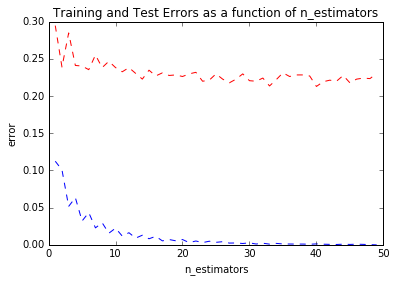

In [25]:
plt.plot(number_estimators, test_errors, 'r--', number_estimators, train_errors, 'b--')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of n_estimators')
plt.show()

In [26]:
train_errors = []
test_errors = []
max_depths = range(1, 20)

for depth in max_depths:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=depth)
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

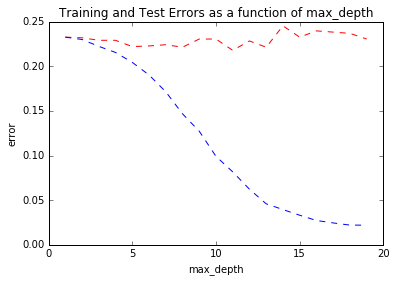

In [27]:
plt.plot(max_depths, test_errors, 'r--', max_depths, train_errors, 'b--')
plt.xlabel('max_depth')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of max_depth')
plt.show()

### Best parameter selection :

According to the graph to avoid overfitting we take max_depth = 10 and n_estimator = 10

### Analising feature importances

mean accuracy: 0.881523272214


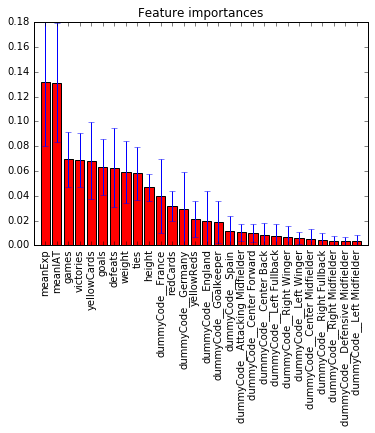

In [28]:
# build a random forest and compute the feature importances
optimal_n_estimators = 10
optimal_max_depth = 10

clf = RandomForestClassifier(n_estimators=optimal_n_estimators, criterion='entropy', max_depth=optimal_max_depth)
clf = clf.fit(X, Y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', clf.score(X,Y))

# plot the feature importances of the random forest
plot_labels = X.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylim([0,0.18])
plt.show()

mean accuracy: 0.855430183357


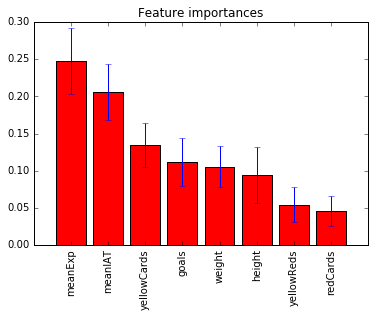

In [29]:
X = clean_data.drop(['skin_cat', 'raterMean', 'ties', 'games', 'defeats', 'victories',
       'dummyCode__England', 'dummyCode__France', 'dummyCode__Germany', 'dummyCode__Spain', 'dummyCode__Attacking Midfielder',
       'dummyCode__Center Back', 'dummyCode__Center Forward', 'dummyCode__Center Midfielder', 'dummyCode__Defensive Midfielder',
       'dummyCode__Goalkeeper', 'dummyCode__Left Fullback', 'dummyCode__Left Midfielder', 'dummyCode__Left Winger',
       'dummyCode__Right Fullback', 'dummyCode__Right Midfielder', 'dummyCode__Right Winger'], axis=1)

Y = np.asarray(clean_data['skin_cat'], dtype="|S6")

clf = RandomForestClassifier(n_estimators=optimal_n_estimators, criterion='entropy', max_depth=optimal_max_depth)
clf = clf.fit(X, Y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', clf.score(X,Y))

# plot the feature importances of the random forest
plot_labels = X.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Bonus part : Train with an increasing part of the datas :

In [30]:
number_splits = 8

train_errors =[]
test_errors = []
sizeOfDatas = range(number_splits,X.shape[0],int(X.shape[0]/15))

for sizeOfData in sizeOfDatas:
    kf = KFold(sizeOfData, n_folds=number_splits)
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy',max_depth = 15)
        clf = clf.fit(X_train, Y_train)
        
        train_error =1- clf.score(X_train, Y_train)
        test_error =1- clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

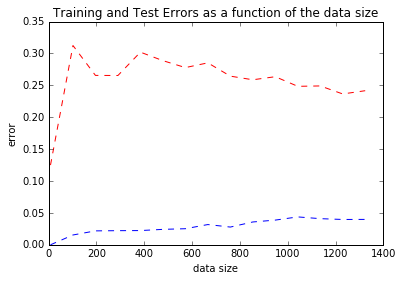

In [31]:
# plot
plt.plot(sizeOfDatas, test_errors, 'r--', sizeOfDatas, train_errors, 'b--')
plt.xlabel('data size')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of the data size')
plt.show()

## 2. Clustering

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

This part consist in culstering the data: it means that we want to put the data in 2 different clusters with the higher accuracy score.

In order to achieve this, we will compute the ***silhouette score*** and the degree of ***accuracy*** corresponding to the result we obtain. 
- First we do that with data containing all the features.
- Then, in order to improve the result we need to find which features are more important than others, and which give us a better silhouette.

=> So we come back with the two DataFrames: X containing all the players with associated features and Y the skin category of each player.

In [33]:
X = clean_data.drop(['skin_cat', 'raterMean'], axis=1)
Y = clean_data['skin_cat']

In [34]:
# clusters the data using K-means and computes the silhouette score
def kmeans_score(data):
    kmean = KMeans(n_clusters=2, init='k-means++')
    kmean.fit(data)
    labels = kmean.labels_
    score = silhouette_score(data, labels, metric='euclidean')
    
    return labels, score

In [35]:
# computes the accuracy for each clustering
def compute_accuracy(prediction_labels, labels):
    correct_predictions = (prediction_labels == labels).sum()
    
    accuracy = correct_predictions / len(labels)
    
    return accuracy

We get the silhouette score, the labels associated, and the accuracy of this clustering. The scores are not good enough, we will try removing features one by one.

In [36]:
labels, score_before = kmeans_score(X)
accuracy_before = compute_accuracy(labels,Y)

print('Silhouette score without feature removal:', score_before)
print('Accuracy without feature removal:', accuracy_before)

Silhouette score without feature removal: 0.535891062512
Accuracy without feature removal: 0.593088857546


This function allows us to know exaclty which features we should remove to get the best silhouette score and the associated accuracy.

It computes the silhouette score for the data without a feature, one by one. Then it retains the best score it could get and try again by removing another one, one by one.
It only keeps the best score with the list of features to remove to get this score.

In [69]:
def remove_features_iteratively(data):
    best_removed_features = []
    removed_features = []
    
    stop_removing = False
    
    prediction_labels, best_score = kmeans_score(data)
    best_accuracy = compute_accuracy(prediction_labels,Y)
    
    while(not stop_removing):
        new_scores = {}
        accuracies = {}
        
        for feature in data.columns:
            labels, score = kmeans_score(data.drop(best_removed_features + removed_features + [feature], axis=1))
            accuracy = compute_accuracy(labels,Y)
            new_scores[feature] = score
            accuracies[feature] = accuracy
            
        feature_to_remove = max(new_scores, key=lambda k: new_scores[k])
        removed_features.append(feature_to_remove)
        best_new_score = new_scores[feature_to_remove]
            
        if(best_score < best_new_score):
            best_score = best_new_score
            best_accuracy = accuracies[feature_to_remove]
            best_removed_features.extend(removed_features)
            removed_features = []
            
        if(len(data.columns) - len(removed_features) - len(best_removed_features) <= 1):
            stop_removing = True
            
    return best_accuracy, best_score, best_removed_features

In [73]:
accuracy_after, best_score, removed_features = remove_features_iteratively(X)

In [74]:
print('silhouette score after feature removal:', best_score)
print('accuracy with feature removal:', accuracy_after)

silhouette score after feature removal: 0.778542883384
accuracy with feature removal: 0.672073342736


The result change at each run. This is quite difficult to be sure about the proper way to do that.